In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysam

# HET SNVs distribution

In [2]:
def load_het_snps(path):
    snvs = defaultdict(list)
    with pysam.VariantFile(path) as f:
        sample = list(f.header.samples)[0]
        for record in f:
            gt = record.samples[sample]["GT"]
            a1, a2 = record.alleles[gt[0]], record.alleles[gt[1]]
            if len(a1) > 1 or len(a2) > 1 or a1 == a2:
                continue
            snvs[record.chrom].append(record.start)
    return snvs
snvs1 = load_het_snps("/lustre/grp/tfclab/chenzg/repositories/GRCh38_HG001_SNP_Indel/GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.vcf.gz")
snvs2 = load_het_snps("../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round1/snvs.vcf.gz")

[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round1/snvs.vcf.gz.tbi


In [3]:
chroms = ["chr%d" % c for c in range(1, 23)] + ["chrX", "chrY"]
chrom_lengths = dict()
with open("/lustre/grp/tfclab/chenzg/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.sizes") as f:
    for line in f:
        chrom, length = line.strip("\n").split("\t")
        chrom_lengths[chrom] = int(length)

In [5]:
def get_het_snv_density(snps, chrom_lengths, width=1000000):
    chrom_counts = dict()
    for chrom in chrom_lengths:
        length = chrom_lengths[chrom]
        nbin = int(length / width)
        if length % width > 0:
            nbin += 1
        counts = np.zeros(nbin, dtype=int)
        for p in snps[chrom]:
            counts[int(p / width)] += 1
        chrom_counts[chrom] = counts
    return chrom_counts

chrom_counts1 = get_het_snv_density(snvs1, chrom_lengths)
chrom_counts2 = get_het_snv_density(snvs2, chrom_lengths)

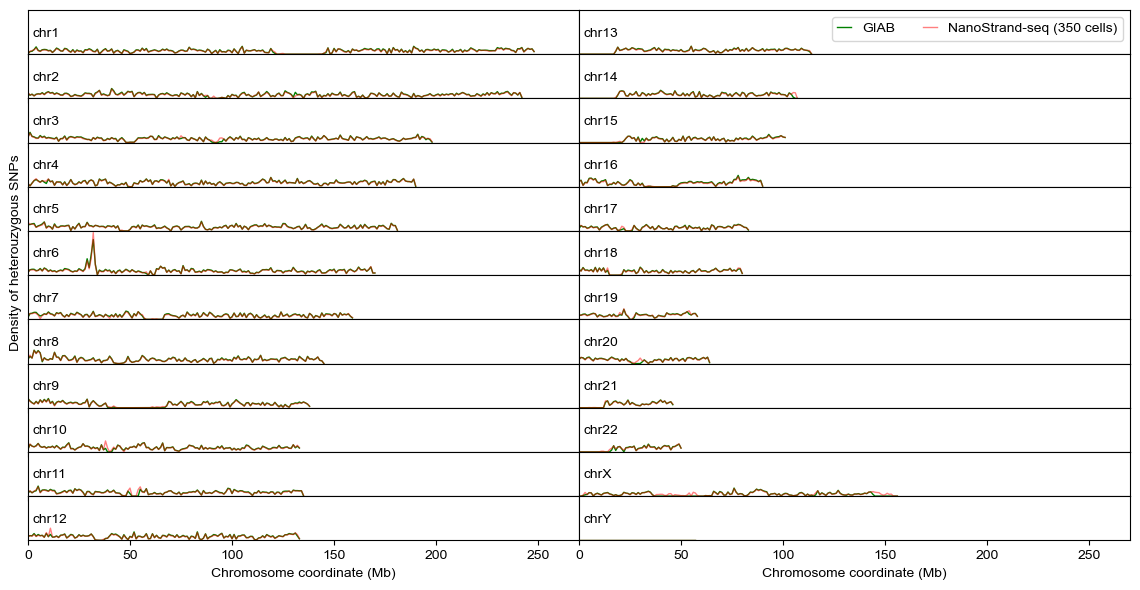

In [6]:
xlim = max([len(counts) for counts in chrom_counts1.values()])
ylim1 = max([max(counts) for counts in chrom_counts1.values()])
ylim2 = max([max(counts) for counts in chrom_counts2.values()])
ylim = max(ylim1, ylim2)
xlim = 270
ylim = 8000
fig, axs = plt.subplots(12, 2, figsize=(11.5, 6), sharex=True, sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})
for i, chrom in enumerate(chroms):
    nrow = i % 12
    ncol = int(i / 12)
    ax = axs[nrow][ncol]
    plt.sca(ax)
    ys1 = chrom_counts1[chrom]
    ys2 = chrom_counts2[chrom]
    xs = np.arange(len(ys1))
    plt.plot(xs, ys1, lw=1, color="green", alpha=1, label="GIAB")
    plt.plot(xs, ys2, lw=1, color="red", alpha=0.5, label="NanoStrand-seq (350 cells)")
    plt.text(2, ylim * 0.4, chrom)
    plt.yticks([])
    if nrow == 11:
        plt.xlabel("Chromosome coordinate (Mb)")
ax = axs[0][1]
ax.legend(ncol=2, frameon=True, bbox_to_anchor=(1, 1), loc="upper right", handlelength=1)
# ax = axs[11][1]
# ax.set_visible(False)
ax = axs[5][0]
ax.set_ylabel("Density of heterouzygous SNPs")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.tight_layout()
plt.savefig("figures/het_snp_distribution.pdf", dpi=300)